In [1]:
from scipy.stats import binom, multinomial
from scipy.optimize import minimize, Bounds, minimize_scalar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from itertools import product

In [2]:
# Edit the font, font size, and axes width

mpl.rcParams['font.family'] = 'Avenir LT Std'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

In [3]:
def optimizar(fun, parametros,minimos,maximos,data,modelo):
    x0 = np.array(parametros)
    bounds = Bounds(minimos,maximos)
#    print("Finding fitting parameters. Please wait...")
    res = minimize(
        fun,
        x0,
#        args=(data,modelo),
        method='trust-constr',
#        method='Nelder-Mead',
#        method='Newton-CG',
        bounds=bounds,
        options={'verbose':0}
    )
    return res

In [3]:
binom.cdf(59, 99, 0.6)

0.5054370011155953

In [4]:
f = lambda p: np.abs(binom.cdf(59, 99, p)-0.5054)
bounds = Bounds(np.array(0),np.array(1))
minimize_scalar(f)

     fun: nan
    nfev: 41
     nit: 37
 success: False
       x: -1.6180339754913822

In [5]:
def objective_function(x):

    return np.abs(binom.cdf(0, 1, x)-0.5)
res = minimize_scalar(objective_function, method='Bounded', bounds=(0,1))

In [6]:
res

     fun: 0.0
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 0.5

In [6]:
def read_models(params_list, model_in):
    list_df = []
    for par in params_list:
        p = '_'.join([str(x) for x in par])
        f_name = f'./model_measurements/{model_in}/{model_in}_{p}.csv'
        test_exp = pd.read_csv(f_name, index_col=0)
        list_df.append(test_exp) 
    df_models = pd.concat(list_df)
    return df_models

In [12]:
def get_partner_choice(x):
    a = [i for i in x]
    a.reverse()
    return a

In [9]:
params_list=[[0.1]]
model_in = 'random'
datas = read_models(params_list, model_in)

In [10]:
datas.sort_values(by=['trial', 'round'])

,round,agent,choice,score,probability,params,trial,eff,fairness
0,1,0,1,1,0.5,[0.1],0,0.015,0.030928
10000,1,1,0,0,0.5,[0.1],0,0.015,0.030928
100,2,0,0,0,0.1,[0.1],0,0.015,0.030928
10100,2,1,0,0,0.1,[0.1],0,0.015,0.030928
200,3,0,1,1,0.1,[0.1],0,0.015,0.030928
...,...,...,...,...,...,...,...,...,...
19799,98,1,0,0,0.1,[0.1],99,0.085,0.075269
9899,99,0,0,0,0.1,[0.1],99,0.085,0.075269
19899,99,1,0,0,0.1,[0.1],99,0.085,0.075269
9999,100,0,0,0,0.1,[0.1],99,0.085,0.075269


#### Deviance

In [85]:
def deviance(theta, Is, ns, model_in):
    if model_in == 'random':
            theta_ = theta*4
    elif model_in == 'p-self':
            theta_ = theta*2
    return -np.sum(binom.logpmf(ns, Is, theta_))

def get_freqs(df):
    datas = df.copy()
    datas.sort_values(by=['trial', 'agent','round'], inplace=True)
    datas['choice_lag'] = datas.groupby(['agent'])['choice'].transform('shift', 1)
    datas['choice_lag'] = pd.Categorical(datas['choice_lag'], categories=[0,1])
    datas['choice_partner'] = datas.groupby(['round'])['choice'].transform(lambda x: get_partner_choice(x))
    datas['choice_partner'] = pd.Categorical(datas['choice_partner'], categories=[0,1])
    datas['choice_partner_lag'] = datas.groupby(['agent'])['choice_partner'].transform('shift', 1)
    ns = datas.groupby(['choice_lag', 'choice_partner_lag'])['choice'].sum().to_numpy()
    return ns

def get_totals(df):
    datas = df.copy()
    datas.sort_values(by=['trial', 'agent','round'], inplace=True)
    datas['choice_lag'] = datas.groupby(['agent'])['choice'].transform('shift', 1)
    datas['choice_lag'] = pd.Categorical(datas['choice_lag'], categories=[0,1])
    datas['choice_partner'] = datas.groupby(['round'])['choice'].transform(lambda x: get_partner_choice(x))
    datas['choice_partner'] = pd.Categorical(datas['choice_partner'], categories=[0,1])
    datas['choice_partner_lag'] = datas.groupby(['agent'])['choice_partner'].transform('shift', 1)
    Is = datas.groupby(['choice_lag', 'choice_partner_lag'])['choice'].count().to_numpy()
    return Is

In [26]:
def optimizar(deviance, parametros,minimos,maximos, Is, ns, model_in):

    x0 = np.array(parametros)
    bounds = Bounds(minimos,maximos)
#    print("Finding fitting parameters. Please wait...")
    res = minimize(
        deviance,
        x0,
        args=(Is, ns, model_in),
        method='trust-constr',
#        method='Nelder-Mead',
#        method='Newton-CG',
        bounds=bounds,
        options={'verbose':0}
    )
    return res

In [23]:
def best_fit(df, model_in, N=10) :
    ns = get_freqs(df)
    Is = get_totals(df)
    if model_in == 'random' or model_in=='belletal':
        num_theta = 1
    elif model_in == 'p-self':
        num_theta = 2
        
    minimos = [0]*num_theta
    maximos = [1]*num_theta
    best_pars=[np.nan]*len(minimos)
    best_fit=10000
    for k in range(N) :
        randomp=np.random.rand(num_theta)
        res=optimizar(deviance, randomp,minimos,maximos,Is, ns, model_in)
        pars=[round(x,2) for x in res.x]
        dev=res.fun
        if dev < best_fit :
            best_fit=dev
            best_pars=pars
    return best_pars, best_fit

In [21]:
def pairs_estimate(params_list, model_in):
    best_fits = []
    for par in params_list:
        par_originals = par
        datas = read_models([par], model_in)
        b_f = best_fit(datas, model_in, N=1)
        best_fits.append((par_originals,b_f[0]))
    return best_fits

In [24]:
def plots_estimate(params_list, model_in):
    result_pairs = pairs_estimate(params_list, model_in)
    result_pairs_np = np.array(result_pairs)
    if model_in == 'random' or model_in == 'belletal':
        num_theta = 1
    elif model_in == 'p-self':
        num_theta = 2
    fig, ax = plt.subplots(1,num_theta, figsize=(num_theta*4,3), tight_layout=True)

    if num_theta > 1:
        for i in range(num_theta):
            ax[i].yaxis.set_tick_params(which='major', size=6, width=0.5, direction='out')
            ax[i].yaxis.set_tick_params(which='minor', size=3, width=0.5, direction='out')
            ax[i].xaxis.set_tick_params(which='major', size=6, width=0.5, direction='out')
            ax[i].xaxis.set_tick_params(which='minor', size=3, width=0.5, direction='out')
            ax[i].set_xlim([0,1])
            ax[i].set_ylim([0,1])
            
            X = result_pairs_np[:,0,i]
            Y = result_pairs_np[:,1,i]
            sns.lineplot(x=X, y=Y, ax=ax[i], color='gray', linestyle='--')
            sns.scatterplot(x=X, y=Y, ax=ax[i], s=60, color='black')
    elif num_theta == 1:
        ax.yaxis.set_tick_params(which='major', size=6, width=0.5, direction='out')
        ax.yaxis.set_tick_params(which='minor', size=3, width=0.5, direction='out')
        ax.xaxis.set_tick_params(which='major', size=6, width=0.5, direction='out')
        ax.xaxis.set_tick_params(which='minor', size=3, width=0.5, direction='out')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        
        X = result_pairs_np[:,0,0]
        Y = result_pairs_np[:,1,0]
        sns.lineplot(x=X, y=Y, ax=ax, color='gray', linestyle='--')
        sns.scatterplot(x=X, y=Y, ax=ax, s=60, color='black')        
    plt.savefig(f'figures/{model_in}.png', dpi=300, transparent=False)

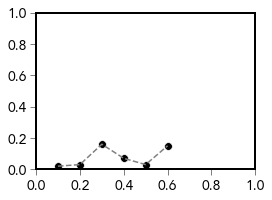

In [109]:
params_list=[[0.1], [0.2], [0.3], [0.4], [0.5], [0.6]]
model_in = 'random'
plots_estimate(params_list, model_in)

C:\Users\samue\miniconda3\envs\machine\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


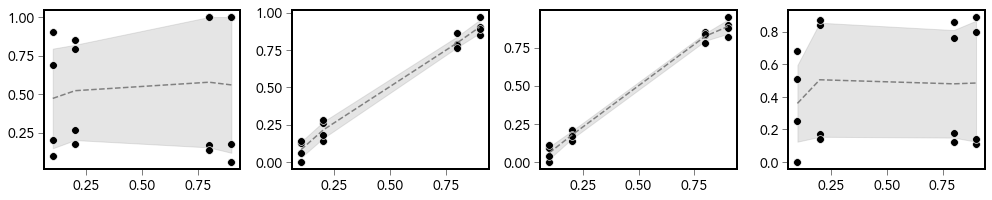

In [71]:
vals = [0.1,0.2,0.8,0.9]
prods = product(vals, repeat=2)
params_list = [list(x) for x in prods]
model_in = 'p-self'
plots_estimate(params_list, model_in)

In [93]:
params_list=[[0.1]]
model_in = 'random'
result_pairs = pairs_estimate(params_list, model_in)
result_pairs_np = np.array(result_pairs)

<ipython-input-93-913a9a550e5e>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  result_pairs_np = np.array(result_pairs)


In [94]:
result_pairs_np

array([[list([0.1]), list([nan, nan, nan, nan])]], dtype=object)

In [98]:
result_pairs

[([0.1], [nan, nan, nan, nan])]

In [78]:
        X = result_pairs_np[:,0,0]
        Y = result_pairs_np[:,1,0]

In [97]:
ns = get_freqs(datas)
Is = get_totals(datas)
optimize([0.5], Is, ns, 'random')

8228.10060122091

#### New try (Collins et al.)

In [149]:
def belletal_deviance(x, df, treshold):
    N = int(treshold*len(df.agent.unique()))
    df = df.sort_values(by=['trial', 'agent', 'round'])
    mu = float(x)
    likelihood = [] 
    for key, grp in df.groupby(['trial', 'agent']):
        #print(grp.head())
        xk = grp.choice.to_numpy()
        attendance_p = np.sum(xk[:5])/5
        Nk = grp.attendance.to_numpy()
        for t in range(grp.shape[0]):
            attendance_p = attendance_p - mu*(Nk[t]-N)*xk[t]
            attendance_p = 1 if attendance_p > 1 else attendance_p
            attendance_p = 0.0001 if attendance_p <= 0 else attendance_p
            #print(Nk[t], N, xk[t], attendance_p)
            likelihood.append(attendance_p if xk[t] == 1 else 1 - attendance_p)
    #print(likelihood[0:10])
    df['likelihood'] = likelihood
    return -np.sum(np.log(likelihood))
    #return df

In [150]:
params_list=[[0.1]]
model_in = 'belletal'
datas = read_models(params_list, model_in)
datas.sort_values(by=['trial', 'agent', 'round'], inplace=True)

In [151]:
datas

,round,agent,choice,score,probability,params,trial,eff,fairness
0,1,0,0,0,0.793025,[0.1],0,0.165,0.333333
1,2,0,1,-1,0.793025,[0.1],0,0.165,0.333333
2,3,0,0,0,0.693025,[0.1],0,0.165,0.333333
3,4,0,1,-1,0.693025,[0.1],0,0.165,0.333333
4,5,0,0,0,0.593025,[0.1],0,0.165,0.333333
...,...,...,...,...,...,...,...,...,...
195,96,1,0,0,0.186754,[0.1],0,0.165,0.333333
196,97,1,0,0,0.186754,[0.1],0,0.165,0.333333
197,98,1,1,1,0.186754,[0.1],0,0.165,0.333333
198,99,1,0,0,0.186754,[0.1],0,0.165,0.333333


In [152]:
datas['attendance'] = datas.groupby(['trial', 'round'])['choice'].transform(sum)

In [153]:
belletal_deviance(0.05, datas, 0.6)

130.98396333098373

In [154]:
def optimizar(deviance, x0, parametros, minimos,maximos):

    bounds = Bounds(minimos,maximos)
#    print("Finding fitting parameters. Please wait...")
    res = minimize(
        deviance,
        x0,
        args=tuple(parametros),
        method='trust-constr',
#        method='Nelder-Mead',
#        method='Newton-CG',
        bounds=bounds,
        options={'verbose':0}
    )
    return res

In [155]:
optimizar(belletal_deviance, 0.4, [datas, 0.6], [0], [1])

 barrier_parameter: 0.00016000000000000007
 barrier_tolerance: 0.00016000000000000007
          cg_niter: 12
      cg_stop_cond: 1
            constr: [array([0.05004521])]
       constr_nfev: [0]
       constr_nhev: [0]
       constr_njev: [0]
    constr_penalty: 1.0
  constr_violation: 0.0
    execution_time: 0.4031045436859131
               fun: 130.9839028146574
              grad: array([0.00302887])
               jac: [<1x1 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>]
   lagrangian_grad: array([4.71396349e-10])
           message: '`gtol` termination condition is satisfied.'
            method: 'tr_interior_point'
              nfev: 28
              nhev: 0
               nit: 17
             niter: 17
              njev: 14
        optimality: 4.713963486051298e-10
            status: 1
           success: True
         tr_radius: 2071.5661262070944
                 v: [array([-0.00302887])]
                 x: arra

#### Try 3

In [17]:
def get_partner_choice(x):
    a = [i for i in x]
    a.reverse()
    return a

def deviance(theta, Is, ns, model_in):
    if model_in == 'random':
        theta_ = theta*4
    elif model_in == 'p-self':
        theta_ = [theta[1], theta[1], theta[0], theta[0]]
    elif model_in == 'p-partner':
        theta_ = [theta[1], theta[0], theta[1], theta[0]]
    elif model_in == 'p-mixed':
        theta_ = theta
    elif model_in == 'belletal':
        theta_ = [sum(ns)/sum(Is), sum(ns)/sum(Is), sum(ns)/sum(Is),(1-theta[0])*(sum(ns)/sum(Is))]
    return -np.sum(binom.logpmf(ns, Is, theta_))

def get_freqs(df):
    datas = df.copy()
    datas.sort_values(by=['trial', 'agent','round'], inplace=True)
    datas['choice_lag'] = datas.groupby(['agent'])['choice'].transform('shift', 1)
    datas['choice_lag'] = pd.Categorical(datas['choice_lag'], categories=[0,1])
    datas['choice_partner'] = datas.groupby(['round'])['choice'].transform(lambda x: get_partner_choice(x))
    datas['choice_partner'] = pd.Categorical(datas['choice_partner'], categories=[0,1])
    datas['choice_partner_lag'] = datas.groupby(['agent'])['choice_partner'].transform('shift', 1)
    ns = datas.groupby(['choice_lag', 'choice_partner_lag'])['choice'].sum()
    return ns

def get_freqs_lag(df):
    datas = df.copy()
    datas.sort_values(by=['trial', 'agent','round'], inplace=True)
    datas['choice_lag'] = datas.groupby(['agent'])['choice'].transform('shift', 1)
    datas['choice_lag'] = pd.Categorical(datas['choice_lag'], categories=[0,1])
    ns = datas.choice_lag.value_counts().to_numpy()
    return ns

def get_totals(df):
    datas = df.copy()
    datas.sort_values(by=['trial', 'agent','round'], inplace=True)
    datas['choice_lag'] = datas.groupby(['agent'])['choice'].transform('shift', 1)
    datas['choice_lag'] = pd.Categorical(datas['choice_lag'], categories=[0,1])
    datas['choice_partner'] = datas.groupby(['round'])['choice'].transform(lambda x: get_partner_choice(x))
    datas['choice_partner'] = pd.Categorical(datas['choice_partner'], categories=[0,1])
    datas['choice_partner_lag'] = datas.groupby(['agent'])['choice_partner'].transform('shift', 1)
    Is = datas.groupby(['choice_lag', 'choice_partner_lag'])['choice'].count().to_numpy()
    return Is

In [18]:
params_list=[[0.1]]
model_in = 'belletal'
datas = read_models(params_list, model_in)
datas.sort_values(by=['trial', 'agent', 'round'], inplace=True)

In [14]:
ns = get_freqs(datas)

In [15]:
Is = get_totals(datas)

In [16]:
ns

choice_lag  choice_partner_lag
0           0                     17
            1                     10
1           0                     15
            1                      7
Name: choice, dtype: int64

In [19]:
deviance([0.12], Is, ns, model_in)

15.544045947416787

In [32]:
params_list=[[0.1], [0.2], [0.4], [0.6]]
model_in = 'belletal'
pairs_estimate(params_list, model_in)

[([0.1], [0.0]), ([0.2], [0.02]), ([0.4], [0.74]), ([0.6], [1.0])]

In [30]:
params_list=[[0.1, 0.9], [0.8, 0.9], [0.9, 0.8]]
model_in = 'p-self'
pairs_estimate(params_list, model_in)

[([0.1, 0.9], [0.11, 0.87]),
 ([0.8, 0.9], [0.81, 0.97]),
 ([0.9, 0.8], [0.87, 0.79])]

In [27]:
params_list=[[0.05], [0.1], [0.2], [0.4], [0.6]]
model_in = 'belletal'
pairs_estimate(params_list, model_in)

[([0.05], [1.0]),
 ([0.1], [0.0]),
 ([0.2], [1.0]),
 ([0.4], [0.0]),
 ([0.6], [1.0])]

Belletal: [0.1],[0.2], [0.4], [0.6], probar próxima vez, comparar con Collins et al.